In [4]:
# For Colab
import sys
if 'google.colab' in sys.modules:
    !pip -q install geopandas 
    !git clone https://github.com/mggg/covid-analysis
    !mv covid-analysis/*.py covid-analysis/data .
    %config InlineBackend.figure_formats = ['svg']

In [5]:
import os
import json
import numpy as np
import cvxpy as cp
import pandas as pd; pd.set_option('display.max_rows', 200)
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
from collections import defaultdict
from state_data import load_state_data
from clinic_data import load_clinic_data

In [6]:
state_code = 'MA'
results_path = os.path.join('results', state_code)
os.makedirs(results_path, exist_ok=True)

In [7]:
state = load_state_data(state_code=state_code,
                        min_dorm_beds=10,
                        prefer_travel_time=False)

/Users/keiferchiang/Desktop/mggg/covid-analysis/state_data.py:110: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  non_acute_care_gdf


In [8]:
colleges_gdf = gpd.read_file('data/MA_Universities/ma_4_year_ipeds.geojson')

In [9]:
outline_gdf = state['outline']
colleges_gdf = colleges_gdf.to_crs(outline_gdf.crs)
clinic_gdf = load_clinic_data().to_crs(outline_gdf.crs)
clinic_gdf = clinic_gdf[clinic_gdf['state'] == 'Massachusetts'].reset_index()

## Spatiality of clinics and universities
In the plot below, <span style="color:blue">universities are blue circles</span> and <span style="color:red">clinics are red squares.</span>

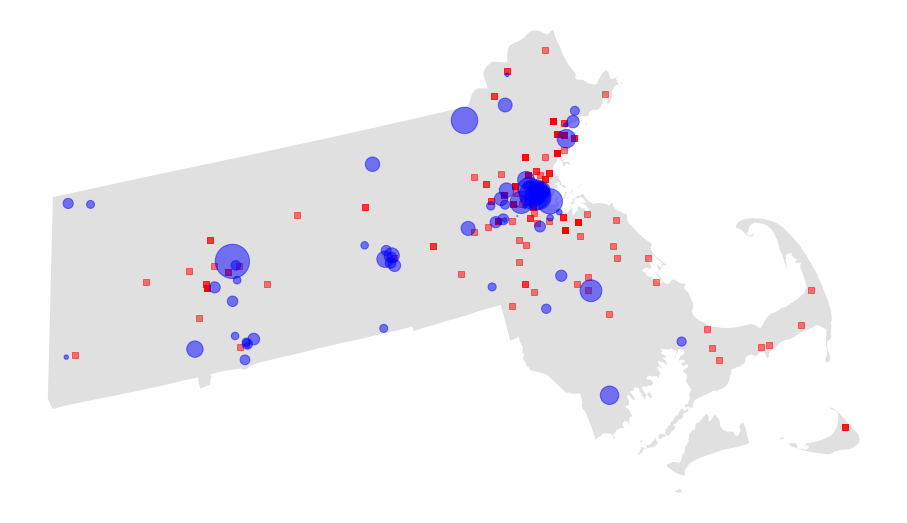

In [10]:
fig, ax = plt.subplots(figsize=(16, 16))
base = outline_gdf.plot(ax=ax, color='#e0e0e0')
clinic_gdf.plot(ax=base, marker='s', color='red', alpha=0.5)
colleges_gdf.plot(ax=base, marker='o', color='blue', alpha=0.5,
                 markersize=0.05 * colleges_gdf['undergrad_enrollment'])
plt.axis('off')
plt.savefig(os.path.join(results_path, f'{state_code}_clinics.png'),
            bbox_inches='tight', dpi=600)
plt.show()

## Broads-CLIAS Assignment
Modified from `University-clinic testing assignment.ipynb`. Generates excel sheets in the `scenarios` directory. CLIA certification data comes from Olivia and Broad data comes from `ma_4_year_ipeds.geojson`.

|                     | Broad Universities             | Non-Broad Universities            |
|---------------------|--------------------------------|-----------------------------------|
| CLIA-Certified Only | `broad_clia_scenarios_v1.xlsx` | `notbroad_clia_scenarios_v1.xlsx` |
| All Clinics         | `broad_all_scenarios_v1.xlsx`  | `notbroad_all_scenarios_v1.xlsx`  |

In [21]:
broad_dataset = "data/MA_Universities/ma_4_year_ipeds.geojson"
raw_broad_gdf = gpd.read_file(broad_dataset)[['broad', 'name', 
                                              'undergrad_enrollment','geometry']]

def filter_broads(gdf, broad_status) -> gpd.GeoDataFrame:
    """
    :param gdf: GeoDataFrame containing broad info
    :param broad_status: True (is Broad) | False (is not Broad)
    :returns: dict
    """
    filtered = []
    geos = []
    def filter(broad, name, enrollment, geometry):
        if broad == broad_status:
            filtered.append([name, enrollment])
            geos.append(geometry)
    [filter(b, n, u, g) for b, n, u, g in zip(gdf['broad'], 
                                              gdf['name'], 
                                              gdf['undergrad_enrollment'],
                                              gdf['geometry'])]
    df = pd.DataFrame(filtered, columns=['name', 'undergrad_enrollment'])
    return gpd.GeoDataFrame(df, crs='epsg:4326', geometry=geos)

broads_gdf = filter_broads(raw_broad_gdf, True)
broads_gdf = broads_gdf.to_crs(outline_gdf.crs)
non_broads_gdf = filter_broads(raw_broad_gdf, False)
non_broads_gdf = non_broads_gdf.to_crs(outline_gdf.crs)

In [35]:
clia_dataset = "preprocess/test-data/test-clia-file.xlsx"

def get_clia_gdf(filename) -> gpd.GeoDataFrame:
    df = pd.read_excel(clia_dataset)
    return gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))

raw_clia_gdf = get_clia_gdf(clia_dataset)[['clia', 'name', 'geometry']]

def filter_clia(gdf) -> gpd.GeoDataFrame:
    filtered = []
    geos = []
    def filter(clia, name, geometry):
        if not isinstance(clia, str):
            filtered.append([name])
            geos.append(geometry)
    [filter(c, n, g) for c, n, g in zip(gdf['clia'], 
                                        gdf['name'], 
                                        gdf['geometry'])]
    df = pd.DataFrame(filtered, columns=['name'])
    return gpd.GeoDataFrame(df, crs='epsg:4326', geometry=geos)

clia_clinics_gdf = filter_clia(raw_clia_gdf)
clia_clinics_gdf = clia_clinics_gdf.to_crs(outline_gdf.crs)
all_clinics_gdf = raw_clia_gdf.drop('clia', 1)
all_clinics_gdf.crs = 'epsg:4326'
all_clinics_gdf = all_clinics_gdf.to_crs(outline_gdf.crs)

In [36]:
geod = pyproj.Geod(ellps='WGS84')

In [37]:
def run_bc_model(percent_tested_per_day, lab_capacity_per_day, 
                 gdf_broads, gdf_clinics):
    # Generate distances
    distances = np.zeros((len(gdf_clinics), len(gdf_broads)))
    clinic_lat_long_gdf = gdf_clinics.to_crs('EPSG:4326')
    colleges_lat_long_gdf = gdf_broads.to_crs('EPSG:4326')
    
    for clinic_idx, clinic_row in enumerate(clinic_lat_long_gdf.itertuples()):
        for ed_idx, ed_row in enumerate(colleges_lat_long_gdf.itertuples()):
            clinic_long, clinic_lat = getattr(clinic_row, 'geometry').coords.xy
            ed_long, ed_lat = getattr(ed_row, 'geometry').coords.xy
            _, _, distance_in_meters = geod.inv(clinic_long, clinic_lat, ed_long, ed_lat)
            distances[clinic_idx, ed_idx] = distance_in_meters[0]
    
    # Supply and demand per day.
    testing_demand = np.round(percent_tested_per_day * 
                              #(1 + staff_to_student_ratio) *
                              gdf_broads['undergrad_enrollment'].to_numpy())
    lab_capacity = lab_capacity_per_day * np.ones(len(gdf_clinics))
    
    total_demand = testing_demand.sum()
    total_capacity = lab_capacity.sum()
    if total_demand > total_capacity:
        return {
            'status': 'infeasible',
            'demand': total_demand,
            'capacity': total_capacity,
            'avg_distance_km': None,
            'avg_distance_mi': None
        }
    
    # Variables
    assignment = cp.Variable((len(gdf_clinics), len(gdf_broads)))
    constraints = [
        assignment >= 0, # Non-negativity.
        cp.sum(assignment, axis=1) <= lab_capacity, # Labs cannot be overutilized.
        cp.sum(assignment, axis=0) == testing_demand, # Demand must be satisfied.
    ]

    # Objective: minimize average travel cost.
    objective = cp.Minimize(cp.sum(cp.multiply(distances, assignment)))
    prob = cp.Problem(objective, constraints=constraints)
    prob.solve()
    avg_distance = np.sum(np.multiply(distances, assignment.value)) / total_demand
    return {
        'status': 'feasible',
        'demand': total_demand,
        'capacity': total_capacity,
        'avg_distance_km': avg_distance / 1000,
        'avg_distance_mi': avg_distance / 1609.34
    }

In [48]:
scenarios = []
broad_clia_scenarios = {
    'broad_all': [],
    'broad_clia': [],
    'notbroad_all': [],
    'notbroad_clia': []
}
for day_interval in (3, 7, 30):
    for capacity_per_day in (100, 200, 500):
        percent_tested_per_day = 1 / day_interval
        
        broad_clia_scenarios['broad_all'].append({
            'day_interval': day_interval,
            'capacity_per_day': capacity_per_day,
            **run_bc_model(percent_tested_per_day, capacity_per_day,
                           broads_gdf, 
                           all_clinics_gdf)
        })
        
        broad_clia_scenarios['broad_clia'].append({
            'day_interval': day_interval,
            'capacity_per_day': capacity_per_day,
            **run_bc_model(percent_tested_per_day, capacity_per_day,
                           broads_gdf, clia_clinics_gdf)
        })
        
        broad_clia_scenarios['notbroad_all'].append({
            'day_interval': day_interval,
            'capacity_per_day': capacity_per_day,
            **run_bc_model(percent_tested_per_day, capacity_per_day,
                           non_broads_gdf, all_clinics_gdf)
        })
        
        
        broad_clia_scenarios['notbroad_clia'].append({
            'day_interval': day_interval,
            'capacity_per_day': capacity_per_day,
            **run_bc_model(percent_tested_per_day, capacity_per_day,
                           non_broads_gdf, clia_clinics_gdf)
        })

In [49]:
for scenarios in broad_clia_scenarios:
    scenarios_df = pd.DataFrame(broad_clia_scenarios[scenarios])
    scenarios_df['avg_distance_km'] = scenarios_df['avg_distance_km'].fillna('')
    scenarios_df['avg_distance_mi'] = scenarios_df['avg_distance_mi'].fillna('')
    scenarios_df.to_excel('scenarios/{}_scenarios_v1.xlsx'.format(scenarios))

In [24]:
"""
def plot_assignments(results):
    fig, ax = plt.subplots(figsize=(16, 16))
    base = outline_gdf.plot(ax=ax, color='#e0e0e0')
    clinic_gdf.plot(ax=base, marker='s', color='red', alpha=0.5)
    colleges_gdf.plot(ax=base, marker='o', color='blue', alpha=0.5,
                     markersize=0.01 * colleges_gdf['undergrad_enrollment'])
    
    for clinic_idx in range(n_lab):
        for ed_idx in range(n_ed):
            if results[clinic_idx, ed_idx] > 0:
                p_lab = clinic_gdf.iloc[clinic_idx].geometry
                p_ed = colleges_gdf.iloc[ed_idx].geometry
                ax.plot([p_lab.x, p_ed.x], [p_lab.y, p_ed.y],
                        color='black',
                        linewidth=0.001 * results[clinic_idx, ed_idx])
                
    plt.axis('off')
"""